In [ ]:
import torchvision
import torch
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import pickle as pkl

list_ = os.listdir('/content/drive/MyDrive/last_layer')

train_list = [elem for elem in list_ if 'train' in elem]
valid_list = [elem for elem in list_ if 'val' in elem]
test_list = set(list_) - set(valid_list) - set(train_list)



## AutoEncoder

In [ ]:
"""
This file defines an AutoEncoder class, which also contains an implementation of neuron resampling.
"""

import torch
import torch.nn as nn
import torch.nn.functional as F

class AutoEncoder(nn.Module):
    def __init__(self, n_inputs: int, n_latents: int, lam: float = 0.003, resampling_interval: int = 25000):
        """
        n_input: Number of inputs
        n_latents: Number of neurons in the hidden layer
        lam: L1-coefficient for Sparse Autoencoder
        resampling_interval: Number of training steps after which dead neurons will be resampled
        """
        super().__init__()
        self.n_inputs, self.n_latents = n_inputs, n_latents
        self.encoder = nn.Linear(n_inputs, n_latents)
        self.relu = nn.ReLU()
        self.decoder = nn.Linear(n_latents, n_inputs)
        self.lam = lam
        self.resampling_interval = resampling_interval
        self.dead_neurons = None
        self.normalize_decoder_columns()

    def forward(self, x):
        latents = self.encode(x)
        reconstructed = self.decode(latents)
        loss = self.calculate_loss(x, latents, reconstructed)

        if self.training:
            return {'loss': loss, 'latents': latents}
        else:
            return {
                'loss': loss,
                'latents': latents,
                'reconst_acts': reconstructed,
                'mse_loss': self.mse_loss(reconstructed, x),
                'l1_loss': self.l1_loss(latents)
            }

    def encode(self, x):
        bias_corrected_input = x - self.decoder.bias
        return self.relu(self.encoder(bias_corrected_input))

    def decode(self, encoded):
        return self.decoder(encoded)

    def calculate_loss(self, x, encoded, reconstructed):
        mse_loss = self.mse_loss(reconstructed, x)
        l1_loss = self.l1_loss(encoded)
        return mse_loss + self.lam * l1_loss

    def mse_loss(self, reconstructed, original):
        return F.mse_loss(reconstructed, original)

    def l1_loss(self, encoded):
        return F.l1_loss(encoded, torch.zeros_like(encoded), reduction='sum') / encoded.shape[0]

    @torch.no_grad()
    def get_feature_activations(self, inputs, start_idx, end_idx):
        """
        Computes the activations of a subset of features in the hidden layer.

        :param inputs: Input tensor of shape (..., n) where n = d_MLP. It includes batch dimensions.
        :param start_idx: Starting index (inclusive) of the feature subset.
        :param end_idx: Ending index (exclusive) of the feature subset.

        Returns the activations for the specified feature range, reducing computation by
        only processing the necessary part of the network's weights and biases.
        """
        adjusted_inputs = inputs - self.decoder.bias  # Adjust input to account for decoder bias
        weight_subset = self.encoder.weight[start_idx:end_idx, :].t()  # Transpose the subset of weights
        bias_subset = self.encoder.bias[start_idx:end_idx]

        activations = self.relu(adjusted_inputs @ weight_subset + bias_subset)

        return activations

    @torch.no_grad()
    def normalize_decoder_columns(self):
        """
        Normalize the decoder's weight vectors to have unit norm along the feature dimension.
        This normalization can help in maintaining the stability of the network's weights.
        """
        self.decoder.weight.data = F.normalize(self.decoder.weight.data, dim=0)

    def remove_parallel_component_of_decoder_grad(self):
        """
        Remove the component of the gradient parallel to the decoder's weight vectors.
        """
        unit_weights = F.normalize(self.decoder.weight, dim=0) # \hat{b}
        proj = (self.decoder.weight.grad * unit_weights).sum(dim=0) * unit_weights
        self.decoder.weight.grad = self.decoder.weight.grad - proj

    @staticmethod
    def is_dead_neuron_investigation_step(step, resampling_interval, num_resamples):
        """
        Determine if the current step is the start of a phase for investigating dead neurons.
        According to Anthropic's specified policy, it occurs at odd multiples of half the resampling interval.
        """
        return (step > 0) and step % (resampling_interval // 2) == 0 and (step // (resampling_interval // 2)) % 2 != 0 and step < resampling_interval * num_resamples

    @staticmethod
    def is_within_neuron_investigation_phase(step, resampling_interval, num_resamples):
        """
        Check if the current step is within a phase where active neurons are investigated.
        This phase occurs in intervals defined in the specified range, starting at odd multiples of half the resampling interval.
        """
        return any(milestone - resampling_interval // 2 <= step < milestone
                   for milestone in range(resampling_interval, resampling_interval * (num_resamples + 1), resampling_interval))

    @torch.no_grad()
    def initiate_dead_neurons(self):
        self.dead_neurons = set(range(self.n_latents))

    @torch.no_grad()
    def update_dead_neurons(self, latents):
        """
        Update the set of dead neurons based on the current feature activations.
        If a neuron is active (has non-zero activation), it is removed from the dead neuron set.
        """
        active_neurons = torch.nonzero(torch.count_nonzero(latents, dim=0), as_tuple=False).view(-1)
        self.dead_neurons.difference_update(active_neurons.tolist())

    @torch.no_grad()
    def resample_dead_neurons(self, data, optimizer, batch_size=8192):
        """
        Resample the dead neurons by resetting their weights and biases based on the characteristics
        of active neurons. Proceeds only if there are dead neurons to resample.
        """
        if not self.dead_neurons:
            return

        device = self._get_device()
        dead_neurons_t, alive_neurons = self._get_neuron_indices()
        average_enc_norm = self._compute_average_norm_of_alive_neurons(alive_neurons)
        probs = self._compute_loss_probabilities(data, batch_size, device)
        selected_examples = self._select_examples_based_on_probabilities(data, probs)

        self._resample_neurons(selected_examples, dead_neurons_t, average_enc_norm, device)
        self._update_optimizer_parameters(optimizer, dead_neurons_t)

        print('Dead neurons resampled successfully!')
        self.dead_neurons = None

    def _get_device(self):
        return next(self.parameters()).device

    def _get_neuron_indices(self):
        dead_neurons_t = torch.tensor(list(self.dead_neurons), device=self._get_device())
        alive_neurons = torch.tensor([i for i in range(self.n_latents) if i not in self.dead_neurons], device=self._get_device())
        return dead_neurons_t, alive_neurons

    def _compute_average_norm_of_alive_neurons(self, alive_neurons):
        return torch.linalg.vector_norm(self.encoder.weight[alive_neurons], dim=1).mean()

    def _compute_loss_probabilities(self, data, batch_size, device):
        num_batches = (len(data) + batch_size - 1) // batch_size
        probs = torch.zeros(len(data), device=device)
        for i in range(num_batches):
            batch_slice = slice(i * batch_size, (i + 1) * batch_size)
            x_batch = data[batch_slice].to(device)
            probs[batch_slice] = self._compute_batch_loss_squared(x_batch)
        return probs.cpu()

    def _compute_batch_loss_squared(self, x_batch):
        latents = self.encode(x_batch)
        reconst_acts = self.decode(latents)
        mselosses = F.mse_loss(reconst_acts, x_batch, reduction='none').sum(dim=1)
        l1losses = F.l1_loss(latents, torch.zeros_like(latents), reduction='none').sum(dim=1)
        return (mselosses + self.lam * l1losses).square()

    def _select_examples_based_on_probabilities(self, data, probs):
        selection_indices = torch.multinomial(probs, num_samples=len(self.dead_neurons))
        return data[selection_indices].to(dtype=torch.float32)

    def _resample_neurons(self, examples, dead_neurons_t, average_enc_norm, device):
        examples_unit_norm = F.normalize(examples, dim=1).to(device)
        self.decoder.weight[:, dead_neurons_t] = examples_unit_norm.T

        # Renormalize examples to have a certain norm and reset encoder weights and biases
        adjusted_examples = examples_unit_norm * average_enc_norm * 0.2
        self.encoder.weight[dead_neurons_t] = adjusted_examples
        self.encoder.bias[dead_neurons_t] = 0

    def _update_optimizer_parameters(self, optimizer, dead_neurons_t):
        for i, param in enumerate(optimizer.param_groups[0]['params']):
            param_state = optimizer.state[param]
            if i in [0, 1]:  # Encoder weights and biases
                param_state['exp_avg'][dead_neurons_t] = 0
                param_state['exp_avg_sq'][dead_neurons_t] = 0
            elif i == 2:  # Decoder weights
                param_state['exp_avg'][:, dead_neurons_t] = 0
                param_state['exp_avg_sq'][:, dead_neurons_t] = 0

In [ ]:
## MY

"""
Train a Sparse AutoEncoder model

Run on a macbook on a Shakespeare dataset as
python train.py --dataset=shakespeare_char --gpt_ckpt_dir=out_sc_1_2_32 --eval_iters=1 --eval_batch_size=16 --batch_size=128 --device=cpu --eval_interval=100 --n_features=1024 --resampling_interval=150 --wandb_log=True
"""
import os
import torch
import numpy as np
import time


## hyperparameters

# training
n_features = 8096
batch_size = 128 # batch size for autoencoder training
l1_coeff = 3e-3
learning_rate = 3e-4
resampling_interval = 25000 # number of training steps after which neuron resampling will be performed
num_resamples = 4 # number of times resampling is to be performed; it is done 4 times in Anthropic's paper
resampling_data_size = 819200
# evaluation
eval_batch_size = 16 # batch size (number of GPT contexts) for evaluation
eval_iters = 200 # number of iterations in the evaluation loop
eval_interval = 30 # number of training steps after which the autoencoder is evaluated
# I/O
save_checkpoint = True # whether to save model, optimizer, etc or not
save_interval = 10000 # number of training steps after which a checkpoint will be saved
out_dir = 'out' # directory containing trained autoencoder model weights
# wandb logging
wandb_log = True
# system
device = 'cuda'
# reproducibility
seed = 1442

# -----------------------------------------------------------------------------
config_keys = [k for k,v in globals().items() if not k.startswith('_') and isinstance(v, (int, float, bool, str))]
#exec(open('configurator.py').read()) # overrides from command line or config file
config = {k: globals()[k] for k in config_keys} # will be useful for logging
# -----------------------------------------------------------------------------

In [ ]:
autoencoder = AutoEncoder(n_inputs = 2048,
                            n_latents = n_features,
                            lam = l1_coeff,
                            resampling_interval = resampling_interval).to(device)
autoencoder.load_state_dict(torch.load('/content/drive/MyDrive/ckpt_final.pt', weights_only=True)['autoencoder'])
autoencoder.eval()

AutoEncoder(
  (encoder): Linear(in_features=2048, out_features=8096, bias=True)
  (relu): ReLU()
  (decoder): Linear(in_features=8096, out_features=2048, bias=True)
)

In [ ]:
autoencoder.encoder.weight

Parameter containing:
tensor([[-0.0051,  0.0026, -0.0266,  ...,  0.0087, -0.0183, -0.0119],
        [ 0.0192,  0.0075, -0.0084,  ...,  0.0145, -0.0199, -0.0069],
        [ 0.0067, -0.0107, -0.0176,  ..., -0.0078, -0.0053,  0.0136],
        ...,
        [ 0.0088, -0.0229, -0.0208,  ...,  0.0160, -0.0169,  0.0166],
        [-0.0225, -0.0179,  0.0082,  ..., -0.0142,  0.0130, -0.0160],
        [-0.0193, -0.0046,  0.0013,  ...,  0.0263, -0.0037,  0.0271]],
       device='cuda:0', requires_grad=True)

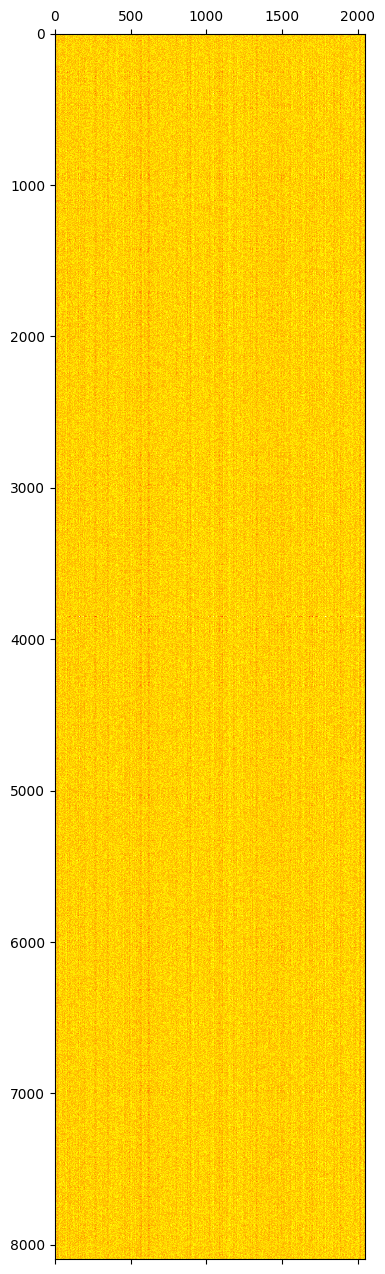

In [ ]:

import matplotlib.pyplot as plt
import numpy as np


plt.matshow(autoencoder.encoder.weight.detach().cpu().numpy(), cmap='hot', )
plt.show()

In [ ]:
!pwd

/content


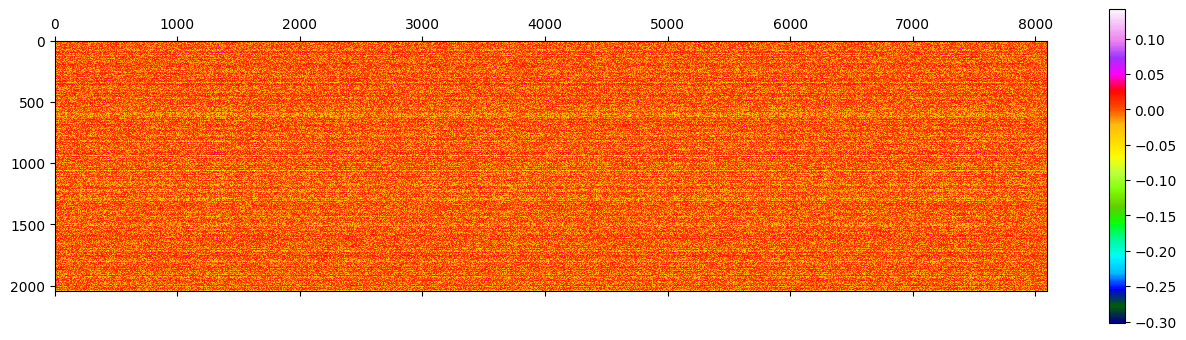

In [ ]:
plt.matshow(autoencoder.encoder.weight.detach().cpu().numpy().T, cmap='gist_ncar')
plt.colorbar()#ticks=[-1, -0.5, 0, 0.5, 1])
#plt.clim(-1,1)
plt.savefig("autoencoder_encoder.pdf", format="pdf")
plt.show()

## save sparse vector

In [ ]:

import tqdm as tqdm

############## SAVE TRAIN ###############

for i, batch in tqdm.tqdm(enumerate(train_list)):
    with open('/content/drive/MyDrive/last_layer/train_'+str(i)+'.pkl', 'rb') as f:
      x = pkl.load(f)

    encoder_output = autoencoder.encode(x).cpu().detach().numpy()

    with open('/content/encode/train_'+str(i)+'.pkl', 'wb') as f:
      pkl.dump(encoder_output, f, protocol=pkl.HIGHEST_PROTOCOL)

    del x, encoder_output
    torch.cuda.empty_cache()






1272it [00:27, 46.68it/s]


In [ ]:
!zip -r /content/all_embeddinds.zip /content/all_embeddinds

  adding: content/all_embeddinds/ (stored 0%)
  adding: content/all_embeddinds/all_test_embedings_sprase.pkl (deflated 100%)
  adding: content/all_embeddinds/all_valid_embedings_sprase.pkl (deflated 100%)
  adding: content/all_embeddinds/all_train_embedings_sprase.pkl (deflated 100%)


In [ ]:
mkdir /content/encode/

In [ ]:

import tqdm as tqdm

############## SAVE VALID ###############

for i, batch in tqdm.tqdm(enumerate(valid_list)):
    with open('/content/drive/MyDrive/last_layer/test_'+str(i)+'wb_val.pkl', 'rb') as f:
      x = pkl.load(f)

    encoder_output = autoencoder.encode(x).cpu().detach().numpy()

    with open('/content/encode/valid_'+str(i)+'.pkl', 'wb') as f:
      pkl.dump(encoder_output, f, protocol=pkl.HIGHEST_PROTOCOL)

    del x, encoder_output
    torch.cuda.empty_cache()


156it [00:02, 65.35it/s]


In [ ]:

import tqdm as tqdm

############## SAVE TEST ###############

for i, batch in tqdm.tqdm(enumerate(test_list)):
    with open('/content/drive/MyDrive/last_layer/test_'+str(i)+'wb.pkl', 'rb') as f:
      x = pkl.load(f)

    encoder_output = autoencoder.encode(x).cpu().detach().numpy()

    with open('/content/encode/test_'+str(i)+'.pkl', 'wb') as f:
      pkl.dump(encoder_output, f, protocol=pkl.HIGHEST_PROTOCOL)

    del x, encoder_output
    torch.cuda.empty_cache()


156it [00:03, 44.82it/s]


In [ ]:
(encoder_output != 0).sum()

tensor(532, device='cuda:0')

In [ ]:
len(train_list)

1272

In [ ]:
x.shape

torch.Size([128, 2048])

In [ ]:
x.

In [ ]:
encoder_output.shape

torch.Size([128, 8096])

## Read hidden values

### train

In [ ]:
import tqdm as tqdm

############## SAVE TRAIN ###############
all_train_embedings = np.empty((0, 8096))


for i, batch in tqdm.tqdm(enumerate(train_list)):

    with open('/content/encode/train_'+str(i)+'.pkl', 'rb') as f:
      code_ = pkl.load(f)
    all_train_embedings = np.concatenate((all_train_embedings, code_))


1272it [38:42,  1.83s/it]


In [ ]:
all_train_embedings.shape

In [ ]:
with open('/content/encode/all_train_embedings_sprase.pkl', 'wb') as f:
  pkl.dump(all_train_embedings, f, protocol=pkl.HIGHEST_PROTOCOL)

In [ ]:
all_train_embedings[0]

array([0., 0., 0., ..., 0., 0., 0.])

In [ ]:
a = (all_train_embedings > 0).sum(axis=0)
a[a != 0]

array([15, 30, 20, ..., 13, 29,  6])

### valid

In [ ]:
import tqdm as tqdm

############## SAVE TRAIN ###############
all_valid_embedings = np.empty((0, 8096))


for i, batch in tqdm.tqdm(enumerate(valid_list)):

    with open('/content/encode/valid_'+str(i)+'.pkl', 'rb') as f:
      code_ = pkl.load(f)
    all_valid_embedings = np.concatenate((all_valid_embedings, code_))


156it [00:39,  3.98it/s]


In [ ]:
all_valid_embedings.shape

(19867, 8096)

In [ ]:
with open('/content/all_embeddinds/all_valid_embedings_sprase.pkl', 'wb') as f:
  pkl.dump(all_valid_embedings, f, protocol=pkl.HIGHEST_PROTOCOL)

### test

In [ ]:
import tqdm as tqdm

############## SAVE TRAIN ###############
all_test_embedings = np.empty((0, 8096))


for i, batch in tqdm.tqdm(enumerate(test_list)):

    with open('/content/encode/test_'+str(i)+'.pkl', 'rb') as f:
      code_ = pkl.load(f)
    all_test_embedings = np.concatenate((all_test_embedings, code_))


156it [00:41,  3.79it/s]


In [ ]:
all_test_embedings.shape

(19962, 8096)

In [ ]:
with open('/content/all_embeddinds/all_test_embedings_sprase.pkl', 'wb') as f:
  pkl.dump(all_test_embedings, f, protocol=pkl.HIGHEST_PROTOCOL)

### split the picrures by category

In [ ]:
(a > 1000).nonzero()

(array([ 318, 2039, 3853, 4501]),)

In [ ]:
all_train_embedings[:,elem]

array([[2.35842323, 0.        , 0.        , 1.0658288 ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.88277662, 1.02354467, 0.        ],
       ...,
       [0.        , 2.07748055, 0.        , 0.        ],
       [0.        , 3.01325083, 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ]])

In [ ]:
dict_id_train = dict()

In [ ]:
(all_train_embedings[:,elem] > 0).nonzero()[0]

array([     0,      0,      2, ..., 162766, 162767, 162768])

In [ ]:
all_train_embedings

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
all_train_embedings[:,elem] > 0

array([[ True, False, False,  True],
       [False, False, False, False],
       [False,  True,  True, False],
       ...,
       [False,  True, False, False],
       [False,  True, False, False],
       [False, False, False, False]])

In [ ]:
(all_train_embedings[:,elem] > 0)

array([ True, False, False, ..., False, False, False])

In [ ]:
dict_id_train = dict()
for elem in (a > 1000).nonzero()[0]:
  dict_id_train[elem] = (all_train_embedings[:,elem] > 0).nonzero()[0]

In [ ]:
with open('/content/drive/MyDrive/encode/dict_id_train.pkl', 'wb') as f:
  pkl.dump(dict_id_train, f, protocol=pkl.HIGHEST_PROTOCOL)

In [ ]:
dict_id_train_plus_one = dict()
for elem in (a > 1000).nonzero()[0]:
  dict_id_train_plus_one[elem] = (all_train_embedings[:,elem] > 0).nonzero()[0] + 1



In [ ]:
with open('/content/drive/MyDrive/encode/dict_id_train_plus_one.pkl', 'wb') as f:
  pkl.dump(dict_id_train_plus_one, f, protocol=pkl.HIGHEST_PROTOCOL)

#correlation check

In [ ]:
import pandas as pd
df = pd.read_csv('celeba_metadata.csv')

In [ ]:
df.head()

,Unnamed: 0,image_id,img_filename,y,split,place
0,0,0,img_align_celeba/000001.jpg,0,0,0
1,1,1,img_align_celeba/000002.jpg,0,0,0
2,2,2,img_align_celeba/000003.jpg,0,0,1
3,3,3,img_align_celeba/000004.jpg,0,0,0
4,4,4,img_align_celeba/000005.jpg,0,0,0


In [ ]:
dict_id_train_plus_one

{318: array([     1,      4,      9, ..., 162754, 162756, 162757]),
 2039: array([     3,      4,     12, ..., 162767, 162768, 162769]),
 3853: array([     3,      5,     10, ..., 162751, 162760, 162761]),
 4501: array([     1,      6,      9, ..., 162752, 162756, 162760])}

In [ ]:
dict_id_train

{318: array([     0,      3,      8, ..., 162753, 162755, 162756]),
 2039: array([     2,      3,     11, ..., 162766, 162767, 162768]),
 3853: array([     2,      4,      9, ..., 162750, 162759, 162760]),
 4501: array([     0,      5,      8, ..., 162751, 162755, 162759])}

In [ ]:
for index in dict_id_train.keys():
  count_blonde = df['y'].values[dict_id_train[index]].sum()
  all_values = len(dict_id_train[index])
  print(str(index))
  print('blonde '+': ', count_blonde, 'noblonde '+': ', all_values-count_blonde)

318
blonde :  20 noblonde :  47947
2039
blonde :  324 noblonde :  59107
3853
blonde :  24120 noblonde :  13562
4501
blonde :  15692 noblonde :  26152


In [ ]:
for index in dict_id_train.keys():
  count_blonde = df['place'].values[dict_id_train[index]].sum()
  all_values = len(dict_id_train[index])
  print(str(index))
  print('men '+': ', count_blonde, 'women'+': ', all_values-count_blonde)

318
men :  9987 women:  37980
2039
men :  43858 women:  15573
3853
men :  5505 women:  32177
4501
men :  2334 women:  39510
